# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a validation set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the validation images.  These predictions will be submitted to the grader.

In [17]:
import numpy as np

train_images = np.load(open('train_images.npy', 'rb'))
train_labels = np.load(open('train_labels.npy', 'rb'))
validation_images = np.load(open('validation_images.npy', 'rb'))

In [4]:
len(validation_images)

10000

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

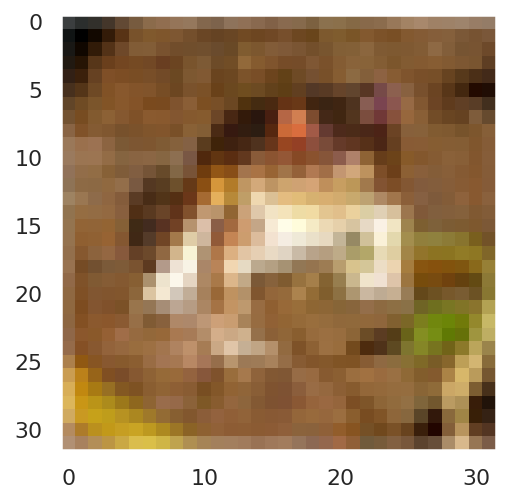

In [6]:
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [35]:
train_labels[0]

6

The human-readable names associated with this classes are

In [36]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
label_names[train_labels[0]]

'frog'

## Perceptual Delta

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

In [5]:
import tensorflow as tf

In [19]:
train_images[0][0][0]#(R,G,B)

array([0.23137255, 0.24313725, 0.24705882])

In [6]:
@tf.function
def c_delta(m,n):
    r_2 = tf.square(tf.subtract(m[:,:,0], n[:,:,0]))
    g_2 = tf.square(tf.subtract(m[:,:,1], n[:,:,1]))
    b_2 = tf.square(tf.subtract(m[:,:,2], n[:,:,2]))
    r_bar = tf.divide(tf.add(m[:,:,0], n[:,:,0]),2)
    c_delta = tf.sqrt(2*r_2 + 4*g_2 + 3*b_2 + r_bar*(r_2-b_2))
    return tf.reduce_sum(c_delta)/(32*32)


@tf.function
def delta_func(images, base):
    return tf.map_fn(lambda x: c_delta(x,base),images)

In [8]:
delta_func(train_images[:10], train_images[0])

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.        , 0.80592714, 1.12634518, 0.46740693, 0.87121572,
       0.70549779, 0.77343272, 0.82417262, 1.12911374, 0.90683418])>

As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first validation image and all of the training images.

In [14]:
deltas = delta_func(train_images, validation_images[0])

In [23]:
nums = deltas.numpy()

In [28]:
indices = list(nums.argsort()[:100])

## Smallest delta model

Instead of comparing each validation image to each training image, let's generate a "typical" image for each class.  This typical image will be the one that minimizes the total (or average) perceptual delta from all training images in this class.  We could do that through some clever averaging, but let's treat it as a minimization problem so that we can do gradient descent.  

This problem will have two steps, the first step is to train a typical image for each class in the training set, the second will be to make predictions on the validation set.  These predictions will be based on the closest "typical" image trained in the first step.

Make the typical image a TensorFlow variable, starting with random pixel values.  It's this TensorFlow variable that we will train by performing gradient descent.

In [35]:
sample = tf.Variable(np.load(open('typical_6.npy','rb')))

download: s3://dataincubator-course/miniprojects/tf/typical_6.npy to ./typical_6.npy


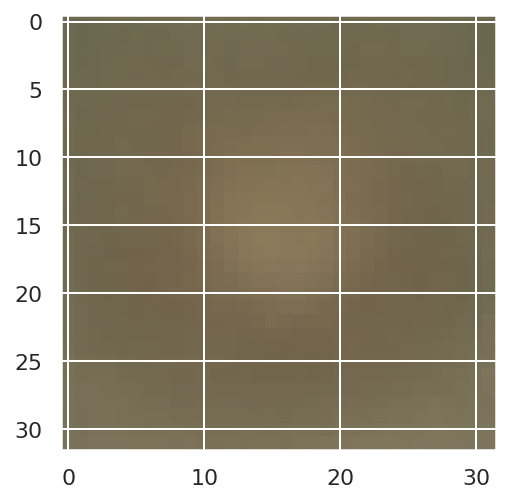

In [50]:
!aws s3 cp s3://dataincubator-course/miniprojects/tf/typical_6.npy .
matplotlib.pyplot.imshow(np.load(open('typical_6.npy','rb')))

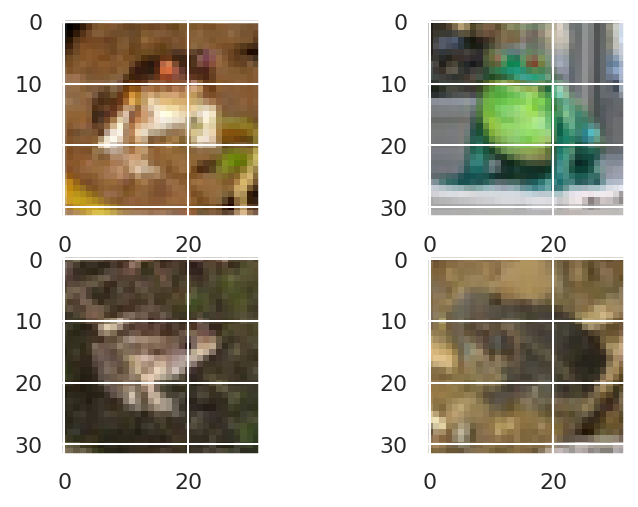

In [51]:
frogs = np.where(train_labels == 6)[0]   #  Get the indices for the frogs

fig, ax = matplotlib.pyplot.subplots(2, 2)
for i in range(4):
    np.ravel(ax)[i].imshow(train_images[ frogs[i] ])

matplotlib.pyplot.show()

In [ ]:
typical_ims = []
for i in range(10):
    img = tf.Variable(tf.random.uniform((32,32,3), dtype=tf.float64))
    label = i
    pics = np.where(train_labels == label)
    ims = train_images[pics]

    ##optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
    with tf.GradientTape() as tape:
        loss = delta_func(ims, img)
    vars_l = [img]
    grads = tape.gradient(loss, vars_l)

    # Process the gradients, for example cap them, etc.
    # capped_grads = [MyCapper(g) for g in grads]
    #processed_grads = [process_gradient(g) for g in grads]

    # Ask the optimizer to apply the processed gradients.
    optimizer.apply_gradients(zip(grads, vars_l))
    typical_ims.append(img)

In [11]:
typical_ims = [tf.cast(typical_ims[i], tf.float32) for i in range(10)]
typical_ims[1]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.5731759 , 0.5614189 , 0.55283785],
        [0.55956525, 0.5728549 , 0.594167  ],
        [0.5302072 , 0.5304576 , 0.50054   ],
        ...,
        [0.64564157, 0.5789572 , 0.5092639 ],
        [0.4456466 , 0.4630331 , 0.45315298],
        [0.61837983, 0.57143414, 0.56724846]],

       [[0.5845522 , 0.5769149 , 0.56259596],
        [0.4106778 , 0.46849075, 0.45349795],
        [0.56149566, 0.55800325, 0.4887231 ],
        ...,
        [0.59813374, 0.53349185, 0.47629458],
        [0.49430692, 0.49281374, 0.4574802 ],
        [0.53296113, 0.55179226, 0.49983656]],

       [[0.62245846, 0.51136744, 0.536841  ],
        [0.5461369 , 0.538463  , 0.5163116 ],
        [0.5985729 , 0.58846295, 0.62114376],
        ...,
        [0.5853335 , 0.5633829 , 0.5433272 ],
        [0.5200495 , 0.46354195, 0.43601787],
        [0.63803405, 0.6202681 , 0.644656  ]],

       ...,

       [[0.55767524, 0.51908755, 0.5251459 ],
        [0.5257

In [9]:
typical_ims[1].numpy()

array([[[0.67826664, 0.6638198 , 0.6954306 ],
        [0.6113198 , 0.59449863, 0.6113254 ],
        [0.60185003, 0.5449062 , 0.5061275 ],
        ...,
        [0.40429756, 0.42553237, 0.38010707],
        [0.4744237 , 0.4770546 , 0.4332734 ],
        [0.43978232, 0.46738663, 0.4409763 ]],

       [[0.5700213 , 0.48965698, 0.41674682],
        [0.52459496, 0.51060843, 0.4682983 ],
        [0.43675473, 0.50112563, 0.49355653],
        ...,
        [0.48100543, 0.5011369 , 0.47289863],
        [0.44234   , 0.4737354 , 0.4737984 ],
        [0.38011327, 0.41182178, 0.3686806 ]],

       [[0.56862736, 0.4997024 , 0.38829768],
        [0.6821952 , 0.64714473, 0.6600446 ],
        [0.5624588 , 0.52853113, 0.48747528],
        ...,
        [0.4992168 , 0.46242532, 0.4246592 ],
        [0.48095387, 0.476429  , 0.4949981 ],
        [0.3979134 , 0.41258666, 0.36642486]],

       ...,

       [[0.5391002 , 0.5166617 , 0.5111878 ],
        [0.46606135, 0.45829892, 0.42968678],
        [0.41932943, 0

In [16]:
len(validation_images)

10000

In [67]:
diff = [c_delta(typical_ims[i],tf.cast(validation_images[0], tf.float32)).numpy() for i in range(10)]
np.argmin(np.asarray(diff)) 

5

In [68]:
predicted_classes = []
for im in validation_images:
    im = tf.cast(im, tf.float32)
    diff = [c_delta(typical_ims[i],im).numpy() for i in range(10)]
    predicted_classes.append(np.argmin(np.asarray(diff)))    

## Softmax model

Looking only at the smallest distance is throwing some information away.  We would expect some classes to have more variation that others.  Also, we would expect correlation between the classes&mdash;a small distance to *cat* is probably more likely for *dog* than for *airplane*.

Instead of a trying to work out these effects heuristically, let the computer do it.  Build a softmax model that takes as input features the distances from all ten typical images and makes a class prediction from those.  Again, use this to predict the class for each of the validation images.

**Hint:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.

In [22]:
class LogisticRegression():
    def __init__(self, eta=.1):
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def _logits(self, X):
        return tf.matmul(X, self.W) + self.b
    
    def loss(self, X, y, return_func=False):
        def loss_():
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                logits=self._logits(X), labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=100000):
        if not hasattr(self, 'W'):
            self.W = tf.Variable(tf.zeros((X.shape[1], 10), dtype=X.dtype))
        if not hasattr(self, 'b'):
            self.b = tf.Variable(tf.zeros((1,10), dtype=X.dtype))
        
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [self.W, self.b])
    
    def predict_proba(self, X):
        return tf.nn.softmax(self._logits(X))
        
    def predict(self, X):
        return tf.argmax(self.predict_proba(X), axis = 1)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X), tf.argmax(y,axis=1)), tf.float64))

In [23]:
model = LogisticRegression()

In [12]:
X_train = []
for im in train_images:
    im = tf.cast(im, tf.float32)
    diff = np.asarray([c_delta(typical_ims[i],im).numpy() for i in range(10)])
    X_train.append(diff) 
X_train = np.asarray(X_train)

In [13]:
X_train.shape

(50000, 10)

In [14]:
y_train = tf.one_hot(train_labels, 10).numpy()
#y_test = tf.one_hot(y_test, 10).numpy()

In [15]:
y_train.shape

(50000, 10)

In [24]:
model.fit(X_train, y_train)

In [17]:
X_test = []
for im in validation_images:
    im = tf.cast(im, tf.float32)
    diff = np.asarray([c_delta(typical_ims[i],im).numpy() for i in range(10)])
    X_test.append(diff) 
X_test = np.asarray(X_test)

In [191]:
y_test = tf.one_hot(train_labels[40000:], 10).numpy()

In [210]:
model.score(X_test,y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2485>

In [25]:
predicted_classes = model.predict(X_test)

In [26]:
predicted_classes = list(predicted_classes.numpy())

## Fully-connected model

The previous model still makes the assumption that this distance metric is the right measure to use.  In this problem, we'll give this up.  Build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
X_train = [np.concatenate(np.concatenate(im)) for im in train_images]

In [ ]:
y_train = train_labels[:49000]

X_t = np.asarray(X_train[:49000])

X_test = np.asarray(X_train[49000:])
y_test = train_labels[49000:]
                          
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)
                          

N_PIXELS= 32 * 32 * 3
N_CLASSES = 10

hidden_size = 64

In [35]:
np.concatenate(np.concatenate(X_train[0])).shape

(3072,)

In [9]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        hidden_size,
        activation='sigmoid',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_t, y_train_hot,
                    epochs=2,
                    batch_size=128,
                    validation_data=(X_test,y_test_hot))

In [9]:
val = [np.concatenate(np.concatenate(im)) for im in validation_images]

In [10]:
predicted_classes = list(np.argmax(model.predict(np.asarray(val)),axis=1))

## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

In [18]:
import tensorflow as tf
from tensorflow import keras

In [12]:
from random import shuffle
X_train = [np.concatenate(np.concatenate(im)) for im in train_images[:10]]

In [16]:
X_train
X_t = np.asarray(X_train)
X_t.shape

(10, 3072)

In [19]:
X_train[0].shape

(3072,)

In [6]:
#shuffle(X_train)
y_train = train_labels[:48000]

X_t = np.asarray(X_train[:48000])

X_test = np.asarray(X_train[48000:])
y_test = train_labels[48000:]
                          
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)                       

In [7]:
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 128
n_epochs = 30

In [8]:
model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dense(n_classes, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_t, y_train_hot,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test_hot))

Train on 48000 samples, validate on 2000 samples
Epoch 1/30
48000/48000 [==============================] - 7s 149us/sample - loss: 1.6386 - accuracy: 0.4165 - val_loss: 1.3788 - val_accuracy: 0.5230
Epoch 2/30
48000/48000 [==============================] - 6s 131us/sample - loss: 1.3589 - accuracy: 0.5198 - val_loss: 1.2906 - val_accuracy: 0.5370
Epoch 3/30
48000/48000 [==============================] - 6s 127us/sample - loss: 1.2697 - accuracy: 0.5507 - val_loss: 1.1628 - val_accuracy: 0.5815
Epoch 4/30
48000/48000 [==============================] - 6s 125us/sample - loss: 1.2010 - accuracy: 0.5741 - val_loss: 1.1169 - val_accuracy: 0.6105
Epoch 5/30
48000/48000 [==============================] - 6s 129us/sample - loss: 1.1466 - accuracy: 0.5946 - val_loss: 1.1066 - val_accuracy: 0.6050
Epoch 6/30
48000/48000 [==============================] - 6s 131us/sample - loss: 1.1022 - accuracy: 0.6109 - val_loss: 1.0605 - val_accuracy: 0.6295
Epoch 7/30
48000/48000 [===========================

In [10]:
val = [np.concatenate(np.concatenate(im)) for im in validation_images]

In [11]:
predicted_classes = list(np.argmax(model.predict(np.asarray(val)),axis=1))

In [ ]:
predicted_classes

## Transfer learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the Inception network used in the Deep Dream notebook.

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken since we recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images should be fed to the `inception` network and then vectorized (you might want to consider the `Flatten` layer from Keras).

We've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that we need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize`.  (Higher orders produce better results, but will take significantly longer!)  The Inception network was trained with pixel values from 0 to 255, so you'll want to scale up the image values appropriately.

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; resizing all 50,000 images at once will cause memory errors.
- The latent vector calculation took us about 2 hours on a single machine.  You might consider distributing the calculation.
- The latent vectors for the first 10 images have an average of 778 non-zero values and an overall average value of 0.578.

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [16]:
for i in range(10):
    images = train_images[i*5000: (i+1)*5000]
    lis = [tf.image.resize(im,[299, 299]).numpy().astype(np.float32) for im in images]
    res = [inception.predict(np.expand_dims(l, axis=0)) for l in lis]
    res_ready = np.asarray(res)
    with open('resize{}.npy'.format(i), 'wb') as f:
        np.save(f, res_ready)
    del res_ready
    del images
    del lis
    del res

In [14]:
#load all files together
ns = []
for i in range(10):
    a = np.load(open("resize{}.npy".format(i),'rb'))
    ns.extend(a)#.reshape(-1,2048))    

In [35]:
latent_vects = np.concatenate(ns)

In [36]:
latent_vects.shape

(50000, 2048)

In [15]:
X_train = ns

In [32]:
y_train = train_labels[:48000]

X_t = np.concatenate(X_train[:48000])

X_test = np.concatenate(X_train[48000:])
y_test = train_labels[48000:]
                          
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(y_train)
y_test_hot = one_hot(y_test)                       

In [33]:
X_t.shape

(48000, 2048)

In [34]:
X_test.shape

(2000, 2048)

In [35]:
N_PIXELS= 299 * 299 * 3
N_CLASSES = 10

hidden_size = 64

In [36]:
X_test.shape

(2000, 2048)

In [37]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        hidden_size,
        activation='sigmoid',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
)


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

In [38]:
history = model.fit(X_t, y_train_hot,
                    epochs=2,
                    batch_size=128,
                    validation_data=(X_test,y_test_hot))

Train on 48000 samples, validate on 2000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 19us/sample - loss: 0.7848 - accuracy: 0.7329 - val_loss: 0.6030 - val_accuracy: 0.7980
Epoch 2/2
48000/48000 [==============================] - 1s 14us/sample - loss: 0.5206 - accuracy: 0.8182 - val_loss: 0.4885 - val_accuracy: 0.8355


In [73]:
del val

In [70]:
lis = [tf.image.resize(im,[299, 299]).numpy().astype(np.float32) for im in validation_images[:10]]

In [9]:
images = validation_images[5000:]
lis = [tf.image.resize(im,[299, 299]).numpy().astype(np.float32) for im in images]
res = [inception.predict(np.expand_dims(l, axis=0)) for l in lis]
res_ready = np.asarray(res)
with open('test1.npy', 'wb') as f:
    np.save(f, res_ready)

In [11]:
test = []
for i in range(2):
    a = np.load(open("test{}.npy".format(i),'rb'))
    test.extend(a)#.reshape(-1,2048))    

In [12]:
val = np.concatenate(test)

In [13]:
val.shape

(10000, 2048)

In [39]:
predicted_classes = list(np.argmax(model.predict(val),axis=1))

In [40]:
predicted_classes

[7,
 9,
 3,
 7,
 2,
 4,
 8,
 7,
 9,
 4,
 8,
 7,
 7,
 3,
 1,
 0,
 9,
 9,
 1,
 8,
 1,
 7,
 0,
 1,
 2,
 9,
 5,
 3,
 1,
 0,
 7,
 2,
 9,
 0,
 6,
 5,
 1,
 2,
 5,
 5,
 8,
 2,
 6,
 7,
 6,
 4,
 7,
 2,
 4,
 2,
 0,
 4,
 9,
 2,
 9,
 6,
 7,
 7,
 0,
 3,
 7,
 4,
 7,
 2,
 9,
 3,
 6,
 9,
 2,
 0,
 3,
 6,
 8,
 0,
 4,
 5,
 2,
 6,
 9,
 1,
 2,
 3,
 9,
 4,
 6,
 7,
 6,
 0,
 0,
 0,
 3,
 3,
 8,
 6,
 6,
 1,
 1,
 1,
 2,
 6,
 5,
 6,
 3,
 2,
 1,
 0,
 8,
 7,
 2,
 0,
 9,
 9,
 9,
 7,
 0,
 2,
 0,
 1,
 2,
 7,
 1,
 3,
 4,
 4,
 1,
 6,
 6,
 7,
 4,
 1,
 7,
 1,
 2,
 3,
 9,
 4,
 8,
 1,
 6,
 7,
 1,
 6,
 5,
 0,
 2,
 3,
 0,
 2,
 9,
 1,
 3,
 2,
 7,
 7,
 7,
 7,
 2,
 6,
 5,
 5,
 2,
 3,
 9,
 4,
 2,
 8,
 6,
 4,
 2,
 1,
 0,
 1,
 0,
 6,
 5,
 0,
 0,
 8,
 9,
 2,
 9,
 3,
 5,
 9,
 8,
 0,
 9,
 8,
 9,
 6,
 3,
 6,
 6,
 3,
 6,
 8,
 2,
 0,
 6,
 9,
 5,
 9,
 2,
 3,
 3,
 5,
 5,
 9,
 3,
 0,
 7,
 9,
 9,
 4,
 5,
 4,
 6,
 9,
 4,
 3,
 9,
 7,
 7,
 8,
 0,
 1,
 1,
 1,
 0,
 6,
 3,
 1,
 6,
 3,
 2,
 6,
 5,
 5,
 9,
 2,
 1,
 3,
 5,
 5,
 1,
 9,
 3,
 0,
 8,
 2,
